In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [35]:
class setup:
    wlen = 0.640 # mkm (light wavelength)
    wlen_err = 0.020 # mkm
    focal = 0.3 # m (focal distance)
    focal_err = 0.01 # m
    nu_err = 0.01 # MHz (frequency err)

    #6
    reflector_displ = 70 * 10 # mkm (displacement of ultrasonic waves reflector)
    reflector_nu = 1.16 # MHz (frequency in measurement)

    #10
    mkm_in_del = 4 # (string tuning coeff)
    x_err = 10 # del (string tuning err)

    #14
    ocular_scl = 6 / 10 # mm/del (ocular scale)
    ocular_scl_err = 0.05

def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

### #6

In [36]:
reflector_v = setup.reflector_displ*1e-6 * 2 * setup.reflector_nu*1e6

print("US waves velocity V = {:.0f} m/s".format(reflector_v))

US waves velocity V = 1624 m/s


### #10

In [37]:
data = mipt.read_excel('data/432A.ods', usecols=['D', 'E', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q'], header=(0,1,2)).dropna(how='all')
data

xsl = {
    "F = 1.16 MHz" : "1.16",
    "F = 1.81 MHz" : "1.81",
    "F = 4.10 MHz" : "4.10",
    "F = 4.60 MHz" : "4.60",
    "F = 3.46 MHz" : "3.46",

    "x, del" : "x"
}

data = mipt.map_excel(data, xsl)
data = data['Classic']
data

1.16        1.81        4.10        4.60        3.46       
     N      x    N      x    N      x    N      x    N      x
0 -3.0    0.0 -3.0  -56.0 -2.0 -137.0 -1.0 -155.0 -1.0 -100.0
1 -2.0   32.0 -2.0    0.0 -1.0    0.0  0.0    0.0  0.0    0.0
2 -1.0   65.0 -1.0   60.0  0.0  136.0  1.0  170.0  1.0  110.0
3  0.0   96.0  0.0  110.0  1.0  268.0  NaN    NaN  NaN    NaN
4  1.0  143.0  1.0  175.0  2.0  407.0  NaN    NaN  NaN    NaN
5  2.0  180.0  2.0  235.0  NaN    NaN  NaN    NaN  NaN    NaN
6  3.0  223.0  3.0  290.0  NaN    NaN  NaN    NaN  NaN    NaN

[1.16, 1.81, 3.46, 4.1, 4.6]
[149.0, 231.85714285714286, 420.0, 542.4, 650.0]
[1494.765100671141, 1498.8539741219963, 1581.7142857142858, 1451.3274336283184, 1358.7692307692307]
[81.67426566378461, 70.32667939936412, 84.36275922204904, 66.57800334244844, 71.8837657929281]
v = (1477 +- 34) m/s


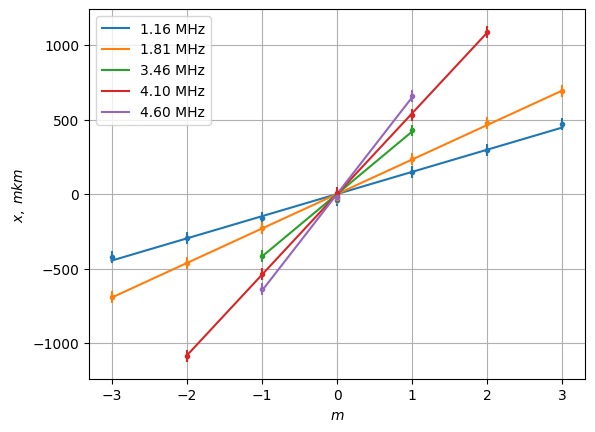

In [38]:
k_arr = []
nu_arr = []
v_arr = []
verr_arr = []

# v = focal * lambda_light * nu / k
def veloc(x):
    return x[0] * x[1] * x[2] / x[3] * 1e6

def plot(d, nu):
    d = d[nu]
    dx = d["x"].dropna() * setup.mkm_in_del
    dN = d["N"].dropna()

    av = np.mean(dx)
    dx -= av
    mipt.plot(dN, dx, label=nu + " MHz", yerr=setup.x_err * setup.mkm_in_del)
    mnk_dat = mipt.mnk(dN, dx)
    k = mnk_dat.get_data()["a"][0]
    k_err = mnk_dat.get_data()["da"][0]

    k_arr.append(k)
    nu_arr.append(float(nu))
    # v_arr.append(setup.focal * setup.wlen * float(nu) / k * 1e6)

    v_arr.append(veloc([setup.focal, setup.wlen, float(nu), k]))
    err, grad = mipt.errcalc(veloc,
                             [setup.focal, setup.wlen, float(nu), k],
                             [setup.focal_err, setup.wlen_err, setup.nu_err, k_err]
    )
    verr_arr.append(err[0])

plot(data, "1.16")
plot(data, "1.81")
plot(data, "3.46")
plot(data, "4.10")
plot(data, "4.60")

plt.xlabel(r"$m$")
plt.ylabel(r"$x, \; mkm$")
plt.grid(True)
plt.legend()
plt.savefig('gen/part1_xn.pdf')

print(nu_arr)
print(k_arr)
print(v_arr)
print(verr_arr)

v = np.mean(v_arr)
verr = np.linalg.norm(verr_arr) / len(v_arr)

print("v = ({:.0f} +- {:.0f}) m/s".format(v, verr))

### #18

In [39]:
data = mipt.read_excel('data/432A.ods', usecols=['T', 'U', 'V', 'W', 'X', 'Y'], header=(0,1,2)).dropna(how='all')
data

xsl = {
    "F = 1.16 MHz" : "1.16",
    "F = 1.54 MHz" : "1.54",
    "F = 1.84 MHz" : "1.84",
}

data = mipt.map_excel(data, xsl)
data = data['Dark']
data

1.16        1.54         1.84       
       N      x    N      x     N      x
0    0.0 -7.284    0 -4.764   0.0 -0.390
1    1.0 -6.343    1 -4.110   1.0  0.177
2    2.0 -4.586    2 -3.413   2.0  0.846
3    3.0 -3.606    3 -2.612   3.0  1.493
4    4.0 -2.357    4 -1.881   4.0  2.314
5    5.0 -1.234    5 -1.077   5.0  2.903
6    6.0 -0.216    6 -0.155   6.0  3.546
7    7.0  0.983    7  0.695   7.0  4.199
8    8.0  2.612    8  1.437   8.0  4.905
9    9.0  3.689    9  2.355   9.0  5.647
10  10.0  5.045   10  3.243  10.0  6.372
11   NaN    NaN   11  3.986  11.0  7.069
12   NaN    NaN   12  4.692   NaN    NaN
13   NaN    NaN   13  5.627   NaN    NaN
14   NaN    NaN   14  6.530   NaN    NaN
15   NaN    NaN   15  7.441   NaN    NaN

[1.16, 1.54, 1.84]
[0.7346509090909091, 0.4919223529411765, 0.4086062937062935]
[1704.390109090909, 1515.1208470588235, 1503.67116083916]
[24.82360215674976, 11.634348824462123, 11.674606374711626]
v = (1574 +- 10) m/s


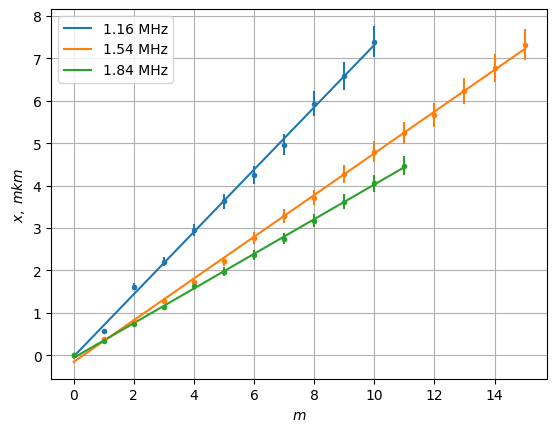

In [40]:
k_arr = []
nu_arr = []
v_arr = []
verr_arr = []

# v = 2 * k * nu
def veloc(x):
    return 2 * x[0] * x[1] * 1e3

def plot(d, nu):
    d = d[nu]
    dx = d["x"].dropna() * setup.ocular_scl # mm
    dN = d["N"].dropna()

    dx -= dx[0]
    mipt.plot(dN, dx, label=nu + " MHz", yerr=dx * setup.ocular_scl_err)
    mnk_dat = mipt.mnk(dN, dx)
    k = mnk_dat.get_data()["a"][0]
    k_err = mnk_dat.get_data()["da"][0]

    k_arr.append(k)
    nu_arr.append(float(nu))
    # v_arr.append(setup.focal * setup.wlen * float(nu) / k * 1e6)

    v_arr.append(veloc([k, float(nu)]))
    err, grad = mipt.errcalc(veloc,
                             [k, float(nu)],
                             [k_err, setup.nu_err]
    )
    verr_arr.append(err[0])

plot(data, "1.16")
plot(data, "1.54")
plot(data, "1.84")

plt.xlabel(r"$m$")
plt.ylabel(r"$x, \; mkm$")
plt.grid(True)
plt.legend()
plt.savefig('gen/part2_xn.pdf')

print(nu_arr)
print(k_arr)
print(v_arr)
print(verr_arr)

v = np.mean(v_arr)
verr = np.linalg.norm(verr_arr) / len(v_arr)

print("v = ({:.0f} +- {:.0f}) m/s".format(v, verr))

### #19

In [41]:
soniclen = k_arr[0] * 2 # mm
print(soniclen)
sin = (setup.wlen*1e-6) / (soniclen*1e-3)

cos = np.sqrt(1 - sin**2)
print(1 - cos)

print(setup.wlen) # mkm

z = 1.5 # m
z * np.pi * setup.wlen / (soniclen**2)

1.4693018181818183
9.486542151826427e-08
0.64


1.397008580904731

(0    1.16
 1    1.54
 2    1.84
 dtype: float64,
 0    1704.390109
 1    1515.120847
 2    1503.671161
 dtype: float64,
 None)

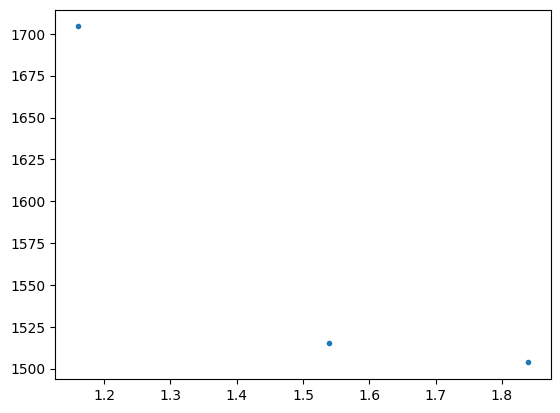

In [42]:
mipt.plot(nu_arr, v_arr, func=None)